LOAN DEFAULT PREDICTION MODEL - CLASSIFYING GOOD/BAD LOANS

APPROACH
1. Data EXploration
    - missing values and how to handle them
    - understand nature of the data
    - unique values in categorical columns
    - Distributions of some of the variables
    - Look for any outliers or anomalies in the data
2. Data Preprocessing
    - Address missing values
    - convert date fields to datetime
    - merge datasets using customer_id
3. Feature Engineering
    - create features from the previous loans dataset,(number of previous loans, average loan amount, total amount paid, average days to repay)
    - Handle categorical variables 
    - scale and normalize numerical features if necessary
4. Model Building 
    - split the merged dataset into training and validation sets
    - Train baseline model and train its performance
    - Train several models and compare their performance
    - Iteratively refine the model and explore other algorithms
    - Use the model that performs best on the validation/test set to make predictions on the test data



ABOUT THE DATA

Demographic data (traindemographics.csv)

customerid (Primary key used to merge to other data)

birthdate (date of birth of the customer)

bank_account_type (type of primary bank account)

longitude_gps

latitude_gps

bank_name_clients (name of the bank)

bank_branch_clients (location of the branch - not compulsory - so missing in a lot of the cases)

employment_status_clients (type of employment that customer has)

level_of_education_clients (highest level of education)

Performance data (trainperf.csv) : This is the repeat loan that the customer has taken for which we need to predict the performance of. Basically, we need to predict whether this loan would default given all previous loans and demographics of a customer.

customerid (Primary key used to merge to other data)

systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)

loannumber (The number of the loan that you have to predict)

approveddate (Date that loan was approved)

creationdate (Date that loan application was created)

loanamount (Loan value taken)

totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees)

termdays (Term of loan)

referredby (customerId of the customer that referred this person - is missing, then not referred)

good_bad_flag (good = settled loan on time; bad = did not settled loan on time) - this is the target variable that we need to predict

Previous loans data (trainprevloans.csv) : This dataset contains all previous loans that the customer had prior to the loan above that we want to predict the performance of. Each loan will have a different systemloanid, but the same customerid for each customer.

customerid (Primary key used to merge to other data)

systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)

loannumber (The number of the loan that you have to predict)

approveddate (Date that loan was approved)

creationdate (Date that loan application was created)

loanamount (Date that loan application was created)

totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees) termdays (Term of loan)

closeddate (Date that the loan was settled)

referredby (customerId of the customer that referred this person - is missing, then not refrerred)

firstduedate (Date of first payment due in cases where the term is longer than 30 days. So in the case where the term is 60+ days - then there are multiple monthly payments due - and this dates reflects the date of the first payment)

firstrepaiddate (Actual date that he/she paid the first payment as defined above)

Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from sklearn.metrics import (classification_report, accuracy_score, roc_auc_score, confusion_matrix, auc)


Data Collection

In [2]:
# Load the data from csv files
train_demographics = pd.read_csv('traindemographics.csv')
train_performance = pd.read_csv('trainperf.csv')
train_previousloans = pd.read_csv('trainprevloans.csv')

test_demographics = pd.read_csv('testdemographics.csv')
test_performance = pd.read_csv('testperf.csv')
test_previousloans = pd.read_csv('testprevloans.csv')

submission = pd.read_csv('SampleSubmission.csv')


In [3]:
# Let's observe the shape of our dataset
print('train demographics data shape :', train_demographics.shape)
print('test demographics data shape :', test_demographics.shape)

train demographics data shape : (4346, 9)
test demographics data shape : (1487, 9)


In [4]:
print('train performance data shape :', train_performance.shape)
print('test performance data shape :', test_performance.shape)

train performance data shape : (4368, 10)
test performance data shape : (1450, 9)


In [5]:
print('train prevloans data shape :', train_previousloans.shape)
print('test prevloans data shape :', test_previousloans.shape)

train prevloans data shape : (18183, 12)
test prevloans data shape : (5907, 12)


In [6]:
# Lets look at the sample submission file
submission.head()

,customerid,Good_Bad_flag
0,8a28afc7474813a40147639ec637156b,1
1,8a3735d5518aba7301518ac34413010d,1
2,8a76e7d443e6e97c0143ed099d102b1d,1
3,8a818823525dceef01525deda2480384,1
4,8a818926522ea5ef01523aff15c37482,1


In [7]:
train_demographics.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


In [8]:
train_performance.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good


In [9]:
train_previousloans.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


Missing Values Check

In [10]:
# Check for missing values
def check_missing_values(train_demographics):
    missing_values = train_demographics.isnull().sum()  # Calculate the sum of missing values for each column
    total_missing = missing_values.sum()  # Calculate the total number of missing values
    percent_missing = (total_missing / train_demographics.size) * 100  # Calculate the percentage of missing values
    
    return missing_values, total_missing, percent_missing

missing_values, total_missing, percent_missing = check_missing_values(train_demographics)

print("Missing Values for train demographics:")
print(missing_values)

print("\nTotal Missing Values:", total_missing)
print("Percentage of Missing Values:", percent_missing, "%")

Missing Values for train demographics:
customerid                       0
birthdate                        0
bank_account_type                0
longitude_gps                    0
latitude_gps                     0
bank_name_clients                0
bank_branch_clients           4295
employment_status_clients      648
level_of_education_clients    3759
dtype: int64

Total Missing Values: 8702
Percentage of Missing Values: 22.247788515621007 %


In [11]:
# Check for missing values
def check_missing_values(train_performance):
    missing_values = train_performance.isnull().sum()  # Calculate the sum of missing values for each column
    total_missing = missing_values.sum()  # Calculate the total number of missing values
    percent_missing = (total_missing / train_performance.size) * 100  # Calculate the percentage of missing values
    
    return missing_values, total_missing, percent_missing

missing_values, total_missing, percent_missing = check_missing_values(train_performance)

print("Missing Values for train performance:")
print(missing_values)

print("\nTotal Missing Values:", total_missing)
print("Percentage of Missing Values:", percent_missing, "%")

Missing Values for train performance:
customerid          0
systemloanid        0
loannumber          0
approveddate        0
creationdate        0
loanamount          0
totaldue            0
termdays            0
referredby       3781
good_bad_flag       0
dtype: int64

Total Missing Values: 3781
Percentage of Missing Values: 8.656135531135531 %


In [12]:
# Check for missing values
def check_missing_values(train_previousloans):
    missing_values = train_previousloans.isnull().sum()  # Calculate the sum of missing values for each column
    total_missing = missing_values.sum()  # Calculate the total number of missing values
    percent_missing = (total_missing / train_previousloans.size) * 100  # Calculate the percentage of missing values
    
    return missing_values, total_missing, percent_missing

missing_values, total_missing, percent_missing = check_missing_values(train_previousloans)

print("Missing Values for train previousloans:")
print(missing_values)

print("\nTotal Missing Values:", total_missing)
print("Percentage of Missing Values:", percent_missing, "%")

Missing Values for train previousloans:
customerid             0
systemloanid           0
loannumber             0
approveddate           0
creationdate           0
loanamount             0
totaldue               0
termdays               0
closeddate             0
referredby         17157
firstduedate           0
firstrepaiddate        0
dtype: int64

Total Missing Values: 17157
Percentage of Missing Values: 7.863113897596656 %


Handling missing values
1. Drop columns with high missing values - (bank_branch_clients, level_of_education_clients, referredby)
2. Impute employment_status_clients with its mode 

In [13]:
# Dropping columns with high missing values
def handling_missing_values_demo(data_demographics):
    data_demographics.drop(["bank_branch_clients", "level_of_education_clients"], axis=1, inplace=True)
    # train_performance.drop("referredby", axis=1, inplace=True)
    # train_previousloans.drop("referredby", axis=1, inplace=True)

    # Imputing employment_status_clients with its mode
    mode_employment_status = data_demographics["employment_status_clients"].mode()[0]
    data_demographics["employment_status_clients"].fillna(mode_employment_status, inplace=True)

In [14]:
handling_missing_values_demo(test_demographics)
handling_missing_values_demo(train_demographics)


In [15]:
def handling_missing_values_perf(data_perf):
    data_perf.drop("referredby", axis=1, inplace=True)
    # train_previousloans.drop("referredby", axis=1, inplace=True)

In [16]:
handling_missing_values_perf(test_performance)
handling_missing_values_perf(train_performance)

In [17]:
def handling_missing_values_prevloans(data_prevloans):
    data_prevloans.drop("referredby", axis=1, inplace=True)


In [18]:
handling_missing_values_prevloans(test_previousloans)
handling_missing_values_prevloans(train_previousloans)

In [19]:
# check if missing values have been handled
missing_demographics_after = train_demographics.isnull().sum()
missing_performance_after = train_performance.isnull().sum()
missing_prevloans_after = train_previousloans.isnull().sum()

missing_demographics_after, missing_performance_after, missing_prevloans_after

(customerid                   0
 birthdate                    0
 bank_account_type            0
 longitude_gps                0
 latitude_gps                 0
 bank_name_clients            0
 employment_status_clients    0
 dtype: int64,
 customerid       0
 systemloanid     0
 loannumber       0
 approveddate     0
 creationdate     0
 loanamount       0
 totaldue         0
 termdays         0
 good_bad_flag    0
 dtype: int64,
 customerid         0
 systemloanid       0
 loannumber         0
 approveddate       0
 creationdate       0
 loanamount         0
 totaldue           0
 termdays           0
 closeddate         0
 firstduedate       0
 firstrepaiddate    0
 dtype: int64)

In [20]:
# check if missing values have been handled
missing_demographics_after = test_demographics.isnull().sum()
missing_performance_after = test_performance.isnull().sum()
missing_prevloans_after = test_previousloans.isnull().sum()

missing_demographics_after, missing_performance_after, missing_prevloans_after

(customerid                   0
 birthdate                    0
 bank_account_type            0
 longitude_gps                0
 latitude_gps                 0
 bank_name_clients            0
 employment_status_clients    0
 dtype: int64,
 customerid      0
 systemloanid    0
 loannumber      0
 approveddate    0
 creationdate    0
 loanamount      0
 totaldue        0
 termdays        0
 dtype: int64,
 customerid         0
 systemloanid       0
 loannumber         0
 approveddate       0
 creationdate       0
 loanamount         0
 totaldue           0
 termdays           0
 closeddate         0
 firstduedate       0
 firstrepaiddate    0
 dtype: int64)

I have handled missing values in both the training and test sets

Merging the dataset
Merge train_previousloans with train performance
Merge the result with train_demographics using an outer join(I will iterate and do this next)

In [21]:
train_merged = train_performance.merge(train_previousloans, on="customerid", suffixes=('_perf', '_prevloans')).merge(train_demographics, on='customerid')
train_merged.head()

,customerid,systemloanid_perf,loannumber_perf,approveddate_perf,creationdate_perf,loanamount_perf,totaldue_perf,termdays_perf,good_bad_flag,systemloanid_prevloans,...,termdays_prevloans,closeddate,firstduedate,firstrepaiddate,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301682320,...,30,2016-09-01 16:06:48.000000,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000,1972-01-15 00:00:00.000000,Other,3.43201,6.433055,Diamond Bank,Permanent
1,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301883808,...,30,2017-05-28 14:44:49.000000,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000,1972-01-15 00:00:00.000000,Other,3.43201,6.433055,Diamond Bank,Permanent
2,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301831714,...,30,2017-04-26 22:18:56.000000,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000,1972-01-15 00:00:00.000000,Other,3.43201,6.433055,Diamond Bank,Permanent
3,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301923941,...,30,2017-06-25 15:24:06.000000,2017-07-03 00:00:00.000000,2017-06-25 15:13:56.000000,1972-01-15 00:00:00.000000,Other,3.43201,6.433055,Diamond Bank,Permanent
4,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,301954468,...,30,2017-07-25 08:14:36.000000,2017-07-31 00:00:00.000000,2017-07-25 08:04:27.000000,1972-01-15 00:00:00.000000,Other,3.43201,6.433055,Diamond Bank,Permanent


In [22]:
train_merged.shape

(13693, 25)

In [23]:
# List of IDs to check
ids_to_check = [
    '8a28afc7474813a40147639ec637156b', '8a3735d5518aba7301518ac34413010d', 
    '8a76e7d443e6e97c0143ed099d102b1d', '8a818823525dceef01525deda2480384', 
    '8a818926522ea5ef01523aff15c37482'
]

# Filter the DataFrame based on the presence of the IDs
filtered_df = train_merged[train_merged['customerid'].isin(ids_to_check)]

filtered_df

,customerid,systemloanid_perf,loannumber_perf,approveddate_perf,creationdate_perf,loanamount_perf,totaldue_perf,termdays_perf,good_bad_flag,systemloanid_prevloans,...,termdays_prevloans,closeddate,firstduedate,firstrepaiddate,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients


In [31]:
test_merged = test_performance.merge(test_previousloans, on="customerid", suffixes=('_perf', '_prevloans')).merge(test_demographics, on='customerid')
test_merged.head()

,customerid,systemloanid_perf,loannumber_perf,approveddate_perf,creationdate_perf,loanamount_perf,totaldue_perf,termdays_perf,systemloanid_prevloans,loannumber_prevloans,...,termdays_prevloans,closeddate,firstduedate,firstrepaiddate,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients
0,8a8589c253ace09b0153af6ba58f1f31,301982236,6,15:11.0,15:04.0,20000,24500.0,30,301627292,3,...,30,2016-07-04 11:34:04.000000,2016-07-04 00:00:00.000000,2016-07-04 11:19:01.000000,1981-09-05 00:00:00.000000,Savings,3.227945,6.586668,UBA,Permanent
1,8a8589c253ace09b0153af6ba58f1f31,301982236,6,15:11.0,15:04.0,20000,24500.0,30,301621095,2,...,15,2016-06-02 00:02:58.000000,2016-05-31 00:00:00.000000,2016-06-01 15:22:34.000000,1981-09-05 00:00:00.000000,Savings,3.227945,6.586668,UBA,Permanent
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,15:11.0,15:04.0,20000,24500.0,30,301803054,4,...,30,2017-03-20 20:49:12.000000,2017-02-27 00:00:00.000000,2017-03-20 20:34:02.000000,1981-09-05 00:00:00.000000,Savings,3.227945,6.586668,UBA,Permanent
3,8a8589c253ace09b0153af6ba58f1f31,301982236,6,15:11.0,15:04.0,20000,24500.0,30,301943779,5,...,30,2017-07-17 13:13:01.000000,2017-07-19 00:00:00.000000,2017-07-17 13:02:52.000000,1981-09-05 00:00:00.000000,Savings,3.227945,6.586668,UBA,Permanent
4,8a8589c253ace09b0153af6ba58f1f31,301982236,6,15:11.0,15:04.0,20000,24500.0,30,301604313,1,...,30,2016-04-24 00:02:46.000000,2016-04-25 00:00:00.000000,2016-04-23 06:23:42.000000,1981-09-05 00:00:00.000000,Savings,3.227945,6.586668,UBA,Permanent


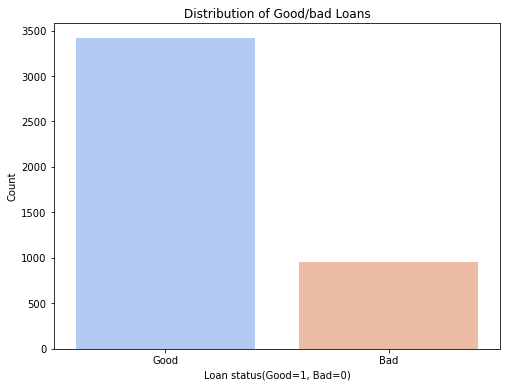

In [24]:
# Explore target(good_bad_flag) distribution

plt.figure(figsize=(8,6))
sns.countplot(x="good_bad_flag", data=train_performance, palette = "coolwarm")
plt.title("Distribution of Good/bad Loans")
plt.xlabel("Loan status(Good=1, Bad=0)")
plt.ylabel("Count")
plt.show()

The distribution of the good_bad_flag shows a class imbalance with good(1) outnumbering the bad(0)

Vizualizing key relationships between key features and target variable
1.Relationship between bank_account_type and good_bad_flag
2.Relationship between employment_status_clients and good_bad_flag
3.Relationship between termdays(loan term in days) and good_bad_flag

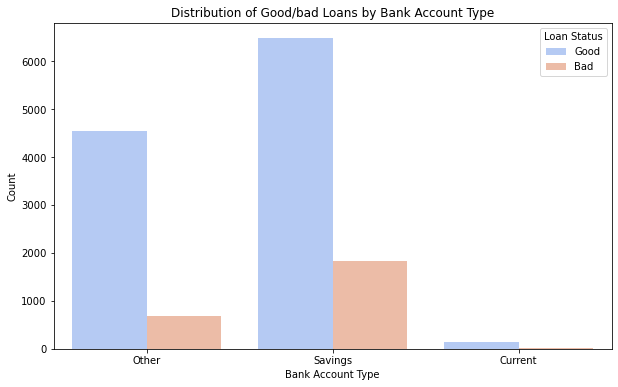

In [25]:
# Relationship between bank_account_type and good_bad_flag
plt.figure(figsize=(10,6))
sns.countplot(x="bank_account_type", hue="good_bad_flag", data=train_merged, palette='coolwarm')
plt.title("Distribution of Good/bad Loans by Bank Account Type")
plt.xlabel("Bank Account Type")
plt.ylabel("Count")
plt.legend(title="Loan Status")
plt.show()

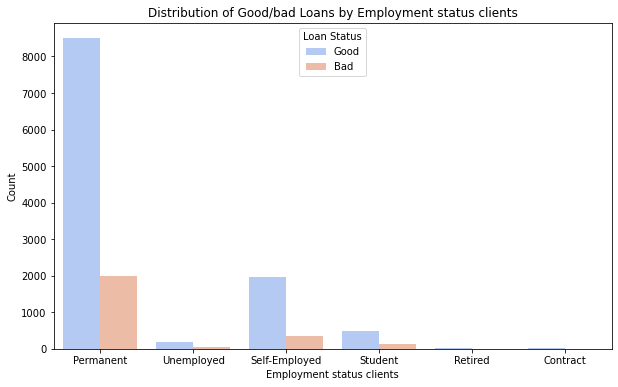

In [26]:
# Relationship between employment_status_clients and good_bad_flag
plt.figure(figsize=(10,6))
sns.countplot(x="employment_status_clients", hue="good_bad_flag", data=train_merged, palette='coolwarm')
plt.title("Distribution of Good/bad Loans by Employment status clients")
plt.xlabel("Employment status clients")
plt.ylabel("Count")
plt.legend(title="Loan Status")
plt.show()

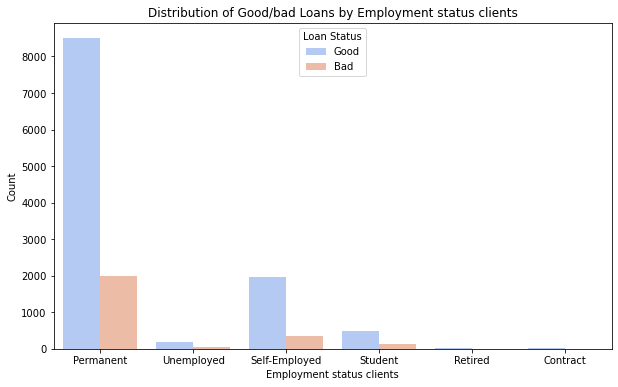

In [27]:
# Distribution of loanamount
plt.figure(figsize=(10,6))
sns.countplot(x="employment_status_clients", hue="good_bad_flag", data=train_merged, palette='coolwarm')
plt.title("Distribution of Good/bad Loans by Employment status clients")
plt.xlabel("Employment status clients")
plt.ylabel("Count")
plt.legend(title="Loan Status")
plt.show()

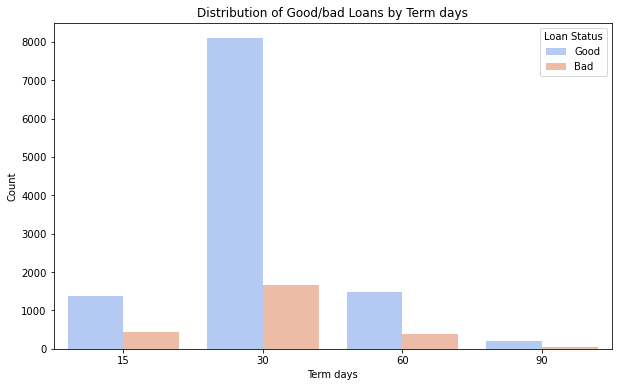

In [28]:
# Relationship between termdays(loan term in days) and good_bad_flag
plt.figure(figsize=(10,6))
sns.countplot(x="termdays_perf", hue="good_bad_flag", data=train_merged, palette='coolwarm')
plt.title("Distribution of Good/bad Loans by Term days")
plt.xlabel("Term days")
plt.ylabel("Count")
plt.legend(title="Loan Status")
plt.show()

Feature Engineering
1. Date features: 
    extracting relevant information from date columns such as day, week, month, year
    convert date columns to datetime
    calculate time intervals btn dates(difference between approveddate and creationdate)
2. Loan related features
3. Previous Loan related features
4. Categorical features
5. Scaling and Normalization


In [29]:
categorical_cols = train_merged.select_dtypes(include=['object']).columns.tolist()
# remove customerid as it is an identifier, remove good_bad_flag as it's our target variable
categorical_cols.remove('customerid')
categorical_cols.remove('good_bad_flag')

categorical_cols

['approveddate_perf',
 'creationdate_perf',
 'approveddate_prevloans',
 'creationdate_prevloans',
 'closeddate',
 'firstduedate',
 'firstrepaiddate',
 'birthdate',
 'bank_account_type',
 'bank_name_clients',
 'employment_status_clients']

In [32]:
categorical_ = test_merged.select_dtypes(include=['object']).columns.tolist()
# remove customerid as it is an identifier, 
categorical_.remove('customerid')

categorical_

['approveddate_perf',
 'creationdate_perf',
 'approveddate_prevloans',
 'creationdate_prevloans',
 'closeddate',
 'firstduedate',
 'firstrepaiddate',
 'birthdate',
 'bank_account_type',
 'bank_name_clients',
 'employment_status_clients']

In [33]:
date_cols = ["approveddate_perf", "creationdate_perf", "approveddate_prevloans", "creationdate_prevloans", "closeddate", "firstduedate", "firstrepaiddate", "birthdate"]

In [34]:
for col in date_cols:
    if train_merged[col].dtype == "object":
        print(col, train_merged[~train_merged[col].astype(str).str.match(r'^\d{4}-\d{2}-\d{2}.*')][col].unique())

approveddate_perf []
creationdate_perf []
approveddate_prevloans []
creationdate_prevloans []
closeddate []
firstduedate []
firstrepaiddate []
birthdate []


In [35]:
# 1. Date Features
# convert date columns to datetime format
for col in date_cols:
    if col in train_merged.columns:
        train_merged[col] = pd.to_datetime(train_merged[col], errors='coerce')

# Extract components from approveddate_perf, creationdate_perf, approveddate_prevloans, 
for col in date_cols:
    train_merged[col + '_dayofweek'] = train_merged[col].dt.dayofweek
    train_merged[col + '_day'] = train_merged[col].dt.day
    train_merged[col + '_month'] = train_merged[col].dt.month
    train_merged[col + '_year'] = train_merged[col].dt.year


# calculate time interval
train_merged["days_between_approval_creation"] = (train_merged["approveddate_perf"] - train_merged["creationdate_perf"]).dt.days

# calculate intervals for prev loans
train_merged["days_between_approval_creation_prevloans"] = (train_merged["approveddate_prevloans"] - train_merged["creationdate_prevloans"]).dt.days


# calculate timelines of first repaymnt
train_merged["timelines_first_repayment"] = (train_merged["firstrepaiddate"] - train_merged["firstduedate"]).dt.days 

# drop the original columns after extracting
train_merged = train_merged.drop(columns=date_cols)

train_merged.head()

,customerid,systemloanid_perf,loannumber_perf,loanamount_perf,totaldue_perf,termdays_perf,good_bad_flag,systemloanid_prevloans,loannumber_prevloans,loanamount_prevloans,...,firstrepaiddate_day,firstrepaiddate_month,firstrepaiddate_year,birthdate_dayofweek,birthdate_day,birthdate_month,birthdate_year,days_between_approval_creation,days_between_approval_creation_prevloans,timelines_first_repayment
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,301682320,2,10000.0,...,1,9,2016,5,15,1,1972,0,0,-13
1,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,301883808,9,10000.0,...,26,5,2017,5,15,1,1972,0,0,-4
2,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,301831714,8,20000.0,...,26,4,2017,5,15,1,1972,0,0,22
3,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,301923941,10,20000.0,...,25,6,2017,5,15,1,1972,0,0,-8
4,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,301954468,11,20000.0,...,25,7,2017,5,15,1,1972,0,0,-6


In [36]:
train_merged.isnull().sum()

customerid                                  0
systemloanid_perf                           0
loannumber_perf                             0
loanamount_perf                             0
totaldue_perf                               0
termdays_perf                               0
good_bad_flag                               0
systemloanid_prevloans                      0
loannumber_prevloans                        0
loanamount_prevloans                        0
totaldue_prevloans                          0
termdays_prevloans                          0
bank_account_type                           0
longitude_gps                               0
latitude_gps                                0
bank_name_clients                           0
employment_status_clients                   0
approveddate_perf_dayofweek                 0
approveddate_perf_day                       0
approveddate_perf_month                     0
approveddate_perf_year                      0
creationdate_perf_dayofweek       

In [37]:
# 1. Date Features
# convert date columns to datetime format
for col in date_cols:
    if col in test_merged.columns:
        test_merged[col] = pd.to_datetime(test_merged[col], errors='coerce')


# Extract components from approveddate_perf, creationdate_perf, approveddate_prevloans, 
for col in date_cols:
    test_merged[col + '_dayofweek'] = test_merged[col].dt.dayofweek
    test_merged[col + '_day'] = test_merged[col].dt.day
    test_merged[col + '_month'] = test_merged[col].dt.month
    test_merged[col + '_year'] = test_merged[col].dt.year


# calculate time interval
test_merged["days_between_approval_creation"] = (test_merged["approveddate_perf"] - test_merged["creationdate_perf"]).dt.days

# calculate intervals for prev loans
test_merged["days_between_approval_creation_prevloans"] = (test_merged["approveddate_prevloans"] - test_merged["creationdate_prevloans"]).dt.days


# calculate timelines of first repaymnt
test_merged["timelines_first_repayment"] = (test_merged["firstrepaiddate"] - test_merged["firstduedate"]).dt.days 

# drop the original columns after extracting
test_merged = test_merged.drop(columns=date_cols)

test_merged.head()

,customerid,systemloanid_perf,loannumber_perf,loanamount_perf,totaldue_perf,termdays_perf,systemloanid_prevloans,loannumber_prevloans,loanamount_prevloans,totaldue_prevloans,...,firstrepaiddate_day,firstrepaiddate_month,firstrepaiddate_year,birthdate_dayofweek,birthdate_day,birthdate_month,birthdate_year,days_between_approval_creation,days_between_approval_creation_prevloans,timelines_first_repayment
0,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,301627292,3,10000.0,13000.0,...,4,7,2016,5,5,9,1981,0.0,0,0
1,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,301621095,2,10000.0,11500.0,...,1,6,2016,5,5,9,1981,0.0,0,1
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,301803054,4,20000.0,23800.0,...,20,3,2017,5,5,9,1981,0.0,0,21
3,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,301943779,5,15000.0,18375.0,...,17,7,2017,5,5,9,1981,0.0,0,-2
4,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,301604313,1,10000.0,13000.0,...,23,4,2016,5,5,9,1981,0.0,0,-2


In [38]:
test_merged.isnull().sum()

customerid                                     0
systemloanid_perf                              0
loannumber_perf                                0
loanamount_perf                                0
totaldue_perf                                  0
termdays_perf                                  0
systemloanid_prevloans                         0
loannumber_prevloans                           0
loanamount_prevloans                           0
totaldue_prevloans                             0
termdays_prevloans                             0
bank_account_type                              0
longitude_gps                                  0
latitude_gps                                   0
bank_name_clients                              0
employment_status_clients                      0
approveddate_perf_dayofweek                 1022
approveddate_perf_day                       1022
approveddate_perf_month                     1022
approveddate_perf_year                      1022
creationdate_perf_da

In [39]:
test_merged.shape

(1605, 51)

In [40]:
# Handling missing values in the test set

# Columns to be imputed using median
cols_median = [
    'approveddate_perf_day', 'approveddate_perf_month', 'approveddate_perf_year',
    'creationdate_perf_day', 'creationdate_perf_month', 'creationdate_perf_year',
    'days_between_approval_creation'
]

# Columns to be imputed using mode
cols_mode = ['approveddate_perf_dayofweek', 'creationdate_perf_dayofweek']

# Impute using median from the training set
for col in cols_median:
    median_val = train_merged[col].median()
    test_merged[col].fillna(median_val, inplace=True)

# Impute using mode from the training set
for col in cols_mode:
    mode_val = train_merged[col].mode()[0]
    test_merged[col].fillna(mode_val, inplace=True)

# Create indicator variables for the columns that had missing values
for col in cols_median + cols_mode:
    test_merged[col + "_missing_ind"] = test_merged[col].isnull().astype(int)

# Check if missing values have been handled
missing_after_imputation = test_merged[cols_median + cols_mode].isnull().sum()
missing_after_imputation

approveddate_perf_day             0
approveddate_perf_month           0
approveddate_perf_year            0
creationdate_perf_day             0
creationdate_perf_month           0
creationdate_perf_year            0
days_between_approval_creation    0
approveddate_perf_dayofweek       0
creationdate_perf_dayofweek       0
dtype: int64

In [41]:
test_merged.columns

Index(['customerid', 'systemloanid_perf', 'loannumber_perf', 'loanamount_perf',
       'totaldue_perf', 'termdays_perf', 'systemloanid_prevloans',
       'loannumber_prevloans', 'loanamount_prevloans', 'totaldue_prevloans',
       'termdays_prevloans', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'employment_status_clients',
       'approveddate_perf_dayofweek', 'approveddate_perf_day',
       'approveddate_perf_month', 'approveddate_perf_year',
       'creationdate_perf_dayofweek', 'creationdate_perf_day',
       'creationdate_perf_month', 'creationdate_perf_year',
       'approveddate_prevloans_dayofweek', 'approveddate_prevloans_day',
       'approveddate_prevloans_month', 'approveddate_prevloans_year',
       'creationdate_prevloans_dayofweek', 'creationdate_prevloans_day',
       'creationdate_prevloans_month', 'creationdate_prevloans_year',
       'closeddate_dayofweek', 'closeddate_day', 'closeddate_month',
       'closeddate_year', 'firstdue

In [42]:
# Drop the indicator columns from the test set
indicator_cols = [col + "_missing_ind" for col in cols_median + cols_mode]
test_merged.drop(columns=indicator_cols, inplace=True, errors='ignore')

About time lines of first repayment
timelines = firstrepaiddate - firstduedate
if timelines is negative, it means the payment was made early.If it's positive, the payment was late, if it's zero, the payment was made exactly on the due date

Loan related features
- calculate the ratio of loanamount to the totaldue to determine the interest rate
- calculate the difference between totaldue and loanamount to get the total interest for the loan
- use the termdays(15,30,60,90) to categorize loans as short-term, medium-term or long-term

In [43]:
# approximation of interest rate
test_merged["loan_to_totaldue_ratio"] = test_merged["loanamount_perf"] / test_merged["totaldue_perf"]

# for previous loans
test_merged["loan_to_totaldue_ratio"] = test_merged["loanamount_prevloans"] / test_merged["totaldue_prevloans"]

# total interest
test_merged["total_interest_approx"] = test_merged["totaldue_perf"] - test_merged["loanamount_perf"]

# for previous loans
test_merged["total_interest_approx"] = test_merged["totaldue_prevloans"] - test_merged["loanamount_prevloans"]


# categorize loans based on term days
bins = [0, 15, 30, 60, 120]
labels = ["very_short_term", "short_term", "medium_term", "long_term"]
# we use pd.cut when we want to segment and sort values into bins
test_merged['loan_term_type_perf'] = pd.cut(test_merged["termdays_perf"], bins=bins, labels=labels, right=False)
test_merged['loan_term_type_prevloans'] = pd.cut(test_merged["termdays_prevloans"], bins=bins, labels=labels, right=False)


In [44]:
test_merged.head()

,customerid,systemloanid_perf,loannumber_perf,loanamount_perf,totaldue_perf,termdays_perf,systemloanid_prevloans,loannumber_prevloans,loanamount_prevloans,totaldue_prevloans,...,birthdate_day,birthdate_month,birthdate_year,days_between_approval_creation,days_between_approval_creation_prevloans,timelines_first_repayment,loan_to_totaldue_ratio,total_interest_approx,loan_term_type_perf,loan_term_type_prevloans
0,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,301627292,3,10000.0,13000.0,...,5,9,1981,0.0,0,0,0.769231,3000.0,medium_term,medium_term
1,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,301621095,2,10000.0,11500.0,...,5,9,1981,0.0,0,1,0.869565,1500.0,medium_term,short_term
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,301803054,4,20000.0,23800.0,...,5,9,1981,0.0,0,21,0.840336,3800.0,medium_term,medium_term
3,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,301943779,5,15000.0,18375.0,...,5,9,1981,0.0,0,-2,0.816327,3375.0,medium_term,medium_term
4,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,301604313,1,10000.0,13000.0,...,5,9,1981,0.0,0,-2,0.769231,3000.0,medium_term,medium_term


In [45]:
# approximation of interest rate
train_merged["loan_to_totaldue_ratio"] = train_merged["loanamount_perf"] / train_merged["totaldue_perf"]

# for previous loans
train_merged["loan_to_totaldue_ratio"] = train_merged["loanamount_prevloans"] / train_merged["totaldue_prevloans"]

# total interest
train_merged["total_interest_approx"] = train_merged["totaldue_perf"] - train_merged["loanamount_perf"]

# for previous loans
train_merged["total_interest_approx"] = train_merged["totaldue_prevloans"] - train_merged["loanamount_prevloans"]


# categorize loans based on term days
bins = [0, 15, 30, 60, 120]
labels = ["very_short_term", "short_term", "medium_term", "long_term"]
# we use pd.cut when we want to segment and sort values into bins
train_merged['loan_term_type_perf'] = pd.cut(train_merged["termdays_perf"], bins=bins, labels=labels, right=False)
train_merged['loan_term_type_prevloans'] = pd.cut(train_merged["termdays_prevloans"], bins=bins, labels=labels, right=False)

In [46]:
train_merged.head()

,customerid,systemloanid_perf,loannumber_perf,loanamount_perf,totaldue_perf,termdays_perf,good_bad_flag,systemloanid_prevloans,loannumber_prevloans,loanamount_prevloans,...,birthdate_day,birthdate_month,birthdate_year,days_between_approval_creation,days_between_approval_creation_prevloans,timelines_first_repayment,loan_to_totaldue_ratio,total_interest_approx,loan_term_type_perf,loan_term_type_prevloans
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,301682320,2,10000.0,...,15,1,1972,0,0,-13,0.769231,3000.0,medium_term,medium_term
1,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,301883808,9,10000.0,...,15,1,1972,0,0,-4,0.769231,3000.0,medium_term,medium_term
2,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,301831714,8,20000.0,...,15,1,1972,0,0,22,0.840336,3800.0,medium_term,medium_term
3,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,301923941,10,20000.0,...,15,1,1972,0,0,-8,0.816327,4500.0,medium_term,medium_term
4,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,301954468,11,20000.0,...,15,1,1972,0,0,-6,0.816327,4500.0,medium_term,medium_term


Previous loan related features
- calculate the number of previous loans for each customer
- calculate the average loanamount, totaldue, termdays from previous loans
- Determine the percentage of previous loans that were repaid before the due date, determine if a customer has defaulted on a previous loan

In [47]:
# calculate number of previous loans
num_prevloans = train_previousloans.groupby('customerid').size()

# convert the results to df
num_prevloans_df = num_prevloans.reset_index(name='num_prevloans')

# merge to main df
train_merged = train_merged.merge(num_prevloans_df, on='customerid', how='left')

train_merged.head()

# Fill NaNs with 0, as customers without prevloans will have Nans after the merge
train_merged['num_prevloans'] = train_merged['num_prevloans'].fillna(0)


In [48]:
num_prevloans = test_previousloans.groupby('customerid').size()

# convert the results to df
num_prevloans_df = num_prevloans.reset_index(name='num_prevloans')

# merge to main df
test_merged = test_merged.merge(num_prevloans_df, on='customerid', how='left')

test_merged.head()

# Fill NaNs with 0, as customers without prevloans will have Nans after the merge
test_merged['num_prevloans'] = test_merged['num_prevloans'].fillna(0)

In [49]:
test_merged.head()

,customerid,systemloanid_perf,loannumber_perf,loanamount_perf,totaldue_perf,termdays_perf,systemloanid_prevloans,loannumber_prevloans,loanamount_prevloans,totaldue_prevloans,...,birthdate_month,birthdate_year,days_between_approval_creation,days_between_approval_creation_prevloans,timelines_first_repayment,loan_to_totaldue_ratio,total_interest_approx,loan_term_type_perf,loan_term_type_prevloans,num_prevloans
0,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,301627292,3,10000.0,13000.0,...,9,1981,0.0,0,0,0.769231,3000.0,medium_term,medium_term,5
1,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,301621095,2,10000.0,11500.0,...,9,1981,0.0,0,1,0.869565,1500.0,medium_term,short_term,5
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,301803054,4,20000.0,23800.0,...,9,1981,0.0,0,21,0.840336,3800.0,medium_term,medium_term,5
3,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,301943779,5,15000.0,18375.0,...,9,1981,0.0,0,-2,0.816327,3375.0,medium_term,medium_term,5
4,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,301604313,1,10000.0,13000.0,...,9,1981,0.0,0,-2,0.769231,3000.0,medium_term,medium_term,5


In [50]:
train_merged.head()

,customerid,systemloanid_perf,loannumber_perf,loanamount_perf,totaldue_perf,termdays_perf,good_bad_flag,systemloanid_prevloans,loannumber_prevloans,loanamount_prevloans,...,birthdate_month,birthdate_year,days_between_approval_creation,days_between_approval_creation_prevloans,timelines_first_repayment,loan_to_totaldue_ratio,total_interest_approx,loan_term_type_perf,loan_term_type_prevloans,num_prevloans
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,301682320,2,10000.0,...,1,1972,0,0,-13,0.769231,3000.0,medium_term,medium_term,11
1,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,301883808,9,10000.0,...,1,1972,0,0,-4,0.769231,3000.0,medium_term,medium_term,11
2,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,301831714,8,20000.0,...,1,1972,0,0,22,0.840336,3800.0,medium_term,medium_term,11
3,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,301923941,10,20000.0,...,1,1972,0,0,-8,0.816327,4500.0,medium_term,medium_term,11
4,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,301954468,11,20000.0,...,1,1972,0,0,-6,0.816327,4500.0,medium_term,medium_term,11


In [51]:
train_merged["num_prevloans"].unique()

array([11,  6,  2,  8,  9,  3,  1, 10, 12, 14,  4,  7,  5, 16, 17, 13, 21,
       15, 18, 26, 19, 22])

every customer had a previous loan

Geographical features
- Use longitude_gps and latitude gps to cluster high-risk and low-risk regions

Aggregation
calculate aggregated metrics for each customer
    - Total number of prev loans
    - Average, minimum, maximum loan amounts
    - Average, minimum, maximum term days
    - Average time btn consecutive loans

In [52]:
train_previousloans["approveddate"] = pd.to_datetime(train_previousloans["approveddate"])

In [53]:
agg_funcs = {
    'loanamount': ['mean', 'min', 'max'],
    'termdays': ['mean', 'min', 'max']

} 

agg_prev_loans = train_previousloans.groupby('customerid').agg(agg_funcs)
agg_prev_loans.columns = ['_'.join(col).strip() for col in agg_prev_loans.columns.values]
agg_prev_loans.reset_index(inplace=True)


# merge aggregated data to main dataset
train_merged = train_merged.merge(agg_prev_loans, on='customerid', how='left')


In [54]:
agg_prev_loans.head()

,customerid,loanamount_mean,loanamount_min,loanamount_max,termdays_mean,termdays_min,termdays_max
0,8a1088a0484472eb01484669e3ce4e0b,10000.000000,10000.0,10000.0,15.000000,15,15
1,8a1a1e7e4f707f8b014f797718316cad,17500.000000,10000.0,30000.0,37.500000,30,60
2,8a1a32fc49b632520149c3b8fdf85139,12857.142857,10000.0,20000.0,19.285714,15,30
3,8a1eb5ba49a682300149c3c068b806c7,16250.000000,10000.0,30000.0,33.750000,30,60
4,8a1edbf14734127f0147356fdb1b1eb2,10000.000000,10000.0,10000.0,22.500000,15,30


In [55]:
agg_funcs = {
    'loanamount': ['mean', 'min', 'max'],
    'termdays': ['mean', 'min', 'max']

} 

agg_prev_loans = test_previousloans.groupby('customerid').agg(agg_funcs)
agg_prev_loans.columns = ['_'.join(col).strip() for col in agg_prev_loans.columns.values]
agg_prev_loans.reset_index(inplace=True)


# merge aggregated data to main dataset
test_merged = test_merged.merge(agg_prev_loans, on='customerid', how='left')

In [56]:
test_merged.head()

,customerid,systemloanid_perf,loannumber_perf,loanamount_perf,totaldue_perf,termdays_perf,systemloanid_prevloans,loannumber_prevloans,loanamount_prevloans,totaldue_prevloans,...,total_interest_approx,loan_term_type_perf,loan_term_type_prevloans,num_prevloans,loanamount_mean,loanamount_min,loanamount_max,termdays_mean,termdays_min,termdays_max
0,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,301627292,3,10000.0,13000.0,...,3000.0,medium_term,medium_term,5,13000.0,10000.0,20000.0,27.0,15,30
1,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,301621095,2,10000.0,11500.0,...,1500.0,medium_term,short_term,5,13000.0,10000.0,20000.0,27.0,15,30
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,301803054,4,20000.0,23800.0,...,3800.0,medium_term,medium_term,5,13000.0,10000.0,20000.0,27.0,15,30
3,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,301943779,5,15000.0,18375.0,...,3375.0,medium_term,medium_term,5,13000.0,10000.0,20000.0,27.0,15,30
4,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,301604313,1,10000.0,13000.0,...,3000.0,medium_term,medium_term,5,13000.0,10000.0,20000.0,27.0,15,30


In [57]:
train_merged.head()

,customerid,systemloanid_perf,loannumber_perf,loanamount_perf,totaldue_perf,termdays_perf,good_bad_flag,systemloanid_prevloans,loannumber_prevloans,loanamount_prevloans,...,total_interest_approx,loan_term_type_perf,loan_term_type_prevloans,num_prevloans,loanamount_mean,loanamount_min,loanamount_max,termdays_mean,termdays_min,termdays_max
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,301682320,2,10000.0,...,3000.0,medium_term,medium_term,11,18181.818182,10000.0,30000.0,30.0,30,30
1,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,301883808,9,10000.0,...,3000.0,medium_term,medium_term,11,18181.818182,10000.0,30000.0,30.0,30,30
2,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,301831714,8,20000.0,...,3800.0,medium_term,medium_term,11,18181.818182,10000.0,30000.0,30.0,30,30
3,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,301923941,10,20000.0,...,4500.0,medium_term,medium_term,11,18181.818182,10000.0,30000.0,30.0,30,30
4,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,301954468,11,20000.0,...,4500.0,medium_term,medium_term,11,18181.818182,10000.0,30000.0,30.0,30,30


In [43]:
train_merged["loan_term_type_perf"].dtype

CategoricalDtype(categories=['very_short_term', 'short_term', 'medium_term', 'long_term'], ordered=True)

In [44]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13693 entries, 0 to 13692
Data columns (total 64 columns):
 #   Column                                    Non-Null Count  Dtype   
---  ------                                    --------------  -----   
 0   customerid                                13693 non-null  object  
 1   systemloanid_perf                         13693 non-null  int64   
 2   loannumber_perf                           13693 non-null  int64   
 3   loanamount_perf                           13693 non-null  float64 
 4   totaldue_perf                             13693 non-null  float64 
 5   termdays_perf                             13693 non-null  int64   
 6   good_bad_flag                             13693 non-null  object  
 7   systemloanid_prevloans                    13693 non-null  int64   
 8   loannumber_prevloans                      13693 non-null  int64   
 9   loanamount_prevloans                      13693 non-null  float64 
 10  totaldue_prevloans    

In [45]:
train_merged.columns

Index(['customerid', 'systemloanid_perf', 'loannumber_perf', 'loanamount_perf',
       'totaldue_perf', 'termdays_perf', 'good_bad_flag',
       'systemloanid_prevloans', 'loannumber_prevloans',
       'loanamount_prevloans', 'totaldue_prevloans', 'termdays_prevloans',
       'bank_account_type', 'longitude_gps', 'latitude_gps',
       'bank_name_clients', 'employment_status_clients',
       'approveddate_perf_dayofweek', 'approveddate_perf_day',
       'approveddate_perf_month', 'approveddate_perf_year',
       'creationdate_perf_dayofweek', 'creationdate_perf_day',
       'creationdate_perf_month', 'creationdate_perf_year',
       'approveddate_prevloans_dayofweek', 'approveddate_prevloans_day',
       'approveddate_prevloans_month', 'approveddate_prevloans_year',
       'creationdate_prevloans_dayofweek', 'creationdate_prevloans_day',
       'creationdate_prevloans_month', 'creationdate_prevloans_year',
       'closeddate_dayofweek', 'closeddate_day', 'closeddate_month',
       'clo

In [53]:
train_merged["bank_name_clients"].unique()

array(['Diamond Bank', 'EcoBank', 'First Bank', 'GT Bank', 'Access Bank',
       'UBA', 'Union Bank', 'FCMB', 'Zenith Bank', 'Stanbic IBTC',
       'Fidelity Bank', 'Wema Bank', 'Sterling Bank', 'Skye Bank',
       'Keystone Bank', 'Heritage Bank', 'Unity Bank',
       'Standard Chartered'], dtype=object)

In [54]:
test_merged["bank_name_clients"].unique()

array(['UBA', 'GT Bank', 'Access Bank', 'First Bank', 'Diamond Bank',
       'Zenith Bank', 'Fidelity Bank', 'Skye Bank', 'Sterling Bank',
       'FCMB', 'EcoBank', 'Heritage Bank', 'Stanbic IBTC', 'Union Bank',
       'Unity Bank', 'Wema Bank'], dtype=object)

Categorical Features

In [58]:
# Encoding categorical features
obj_cols = ["bank_account_type", "bank_name_clients", "employment_status_clients", "loan_term_type_perf", "loan_term_type_prevloans"]

# one-hot encoding
train_encoded = pd.get_dummies(train_merged, columns=obj_cols, drop_first=True)
print(train_encoded.head())
print(train_encoded.shape)

                         customerid  systemloanid_perf  loannumber_perf  \
0  8a2a81a74ce8c05d014cfb32a0da1049          301994762               12   
1  8a2a81a74ce8c05d014cfb32a0da1049          301994762               12   
2  8a2a81a74ce8c05d014cfb32a0da1049          301994762               12   
3  8a2a81a74ce8c05d014cfb32a0da1049          301994762               12   
4  8a2a81a74ce8c05d014cfb32a0da1049          301994762               12   

   loanamount_perf  totaldue_perf  termdays_perf good_bad_flag  \
0          30000.0        34500.0             30          Good   
1          30000.0        34500.0             30          Good   
2          30000.0        34500.0             30          Good   
3          30000.0        34500.0             30          Good   
4          30000.0        34500.0             30          Good   

   systemloanid_prevloans  loannumber_prevloans  loanamount_prevloans  ...  \
0               301682320                     2               10000.0  ...

In [59]:
obj_cols = ["bank_account_type", "bank_name_clients", "employment_status_clients", "loan_term_type_perf", "loan_term_type_prevloans"]

# one-hot encoding
test_encoded = pd.get_dummies(test_merged, columns=obj_cols, drop_first=True)
print(test_encoded.head())
print(test_encoded.shape)

                         customerid  systemloanid_perf  loannumber_perf  \
0  8a8589c253ace09b0153af6ba58f1f31          301982236                6   
1  8a8589c253ace09b0153af6ba58f1f31          301982236                6   
2  8a8589c253ace09b0153af6ba58f1f31          301982236                6   
3  8a8589c253ace09b0153af6ba58f1f31          301982236                6   
4  8a8589c253ace09b0153af6ba58f1f31          301982236                6   

   loanamount_perf  totaldue_perf  termdays_perf  systemloanid_prevloans  \
0            20000        24500.0             30               301627292   
1            20000        24500.0             30               301621095   
2            20000        24500.0             30               301803054   
3            20000        24500.0             30               301943779   
4            20000        24500.0             30               301604313   

   loannumber_prevloans  loanamount_prevloans  totaldue_prevloans  ...  \
0                 

In [60]:
# Checking for missing cols after encoding, there are columns that are in the training but missing in the test

missing_cols = set(train_encoded.columns) - set(test_encoded.columns)
missing_cols.remove('good_bad_flag')

for col in missing_cols:
    test_encoded[col] = 0

missing_cols

{'bank_name_clients_Keystone Bank',
 'bank_name_clients_Standard Chartered',
 'employment_status_clients_Permanent'}

In [61]:
# reorder the columns to match in training set
cols_to_order = [col for col in train_encoded.columns if col != 'good_bad_flag']

test_encoded = test_encoded[cols_to_order]


In [62]:
train_encoded.head()

,customerid,systemloanid_perf,loannumber_perf,loanamount_perf,totaldue_perf,termdays_perf,good_bad_flag,systemloanid_prevloans,loannumber_prevloans,loanamount_prevloans,...,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,loan_term_type_perf_short_term,loan_term_type_perf_medium_term,loan_term_type_perf_long_term,loan_term_type_prevloans_short_term,loan_term_type_prevloans_medium_term,loan_term_type_prevloans_long_term
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,301682320,2,10000.0,...,0,0,0,0,0,1,0,0,1,0
1,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,301883808,9,10000.0,...,0,0,0,0,0,1,0,0,1,0
2,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,301831714,8,20000.0,...,0,0,0,0,0,1,0,0,1,0
3,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,301923941,10,20000.0,...,0,0,0,0,0,1,0,0,1,0
4,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,301954468,11,20000.0,...,0,0,0,0,0,1,0,0,1,0


In [63]:
test_encoded.head()

,customerid,systemloanid_perf,loannumber_perf,loanamount_perf,totaldue_perf,termdays_perf,systemloanid_prevloans,loannumber_prevloans,loanamount_prevloans,totaldue_prevloans,...,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,loan_term_type_perf_short_term,loan_term_type_perf_medium_term,loan_term_type_perf_long_term,loan_term_type_prevloans_short_term,loan_term_type_prevloans_medium_term,loan_term_type_prevloans_long_term
0,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,301627292,3,10000.0,13000.0,...,0,0,0,0,0,1,0,0,1,0
1,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,301621095,2,10000.0,11500.0,...,0,0,0,0,0,1,0,1,0,0
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,301803054,4,20000.0,23800.0,...,0,0,0,0,0,1,0,0,1,0
3,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,301943779,5,15000.0,18375.0,...,0,0,0,0,0,1,0,0,1,0
4,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,301604313,1,10000.0,13000.0,...,0,0,0,0,0,1,0,0,1,0


Feature scaling and Normalization - techniques used to standardize the range of independent variables of the data.
Methods
1.Min-Max scaling - transforms features by scaling each feature to a given range, usually [0,1], [-1,1]
2.Standard SCaling(Z-score normalization) - features will be rescaled so that they will have the properties of a standard normal distribution with mean=0 and std=1
3.Robust Scaling - uses the median and the interquartile range, if outliers are present, this method are robust to them.

In [64]:
train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13693 entries, 0 to 13692
Data columns (total 88 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   customerid                                13693 non-null  object 
 1   systemloanid_perf                         13693 non-null  int64  
 2   loannumber_perf                           13693 non-null  int64  
 3   loanamount_perf                           13693 non-null  float64
 4   totaldue_perf                             13693 non-null  float64
 5   termdays_perf                             13693 non-null  int64  
 6   good_bad_flag                             13693 non-null  object 
 7   systemloanid_prevloans                    13693 non-null  int64  
 8   loannumber_prevloans                      13693 non-null  int64  
 9   loanamount_prevloans                      13693 non-null  float64
 10  totaldue_prevloans                

In [65]:
print(train_encoded.dtypes.value_counts())

int64      44
uint8      30
float64    12
object      2
dtype: int64


Scaling and Normalization

In [66]:
scaler = StandardScaler()
# select numeric columns
numeric_cols = train_encoded.select_dtypes(include=["int64", "float64"]).columns.drop(["systemloanid_perf", "systemloanid_prevloans"])
# applying the scaler
train_encoded[numeric_cols] = scaler.fit_transform(train_encoded[numeric_cols])

train_encoded

,customerid,systemloanid_perf,loannumber_perf,loanamount_perf,totaldue_perf,termdays_perf,good_bad_flag,systemloanid_prevloans,loannumber_prevloans,loanamount_prevloans,...,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,loan_term_type_perf_short_term,loan_term_type_perf_medium_term,loan_term_type_perf_long_term,loan_term_type_prevloans_short_term,loan_term_type_prevloans_medium_term,loan_term_type_prevloans_long_term
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,0.833349,0.341494,0.340346,-0.223946,Good,301682320,-0.673132,-0.700385,...,0,0,0,0,0,1,0,0,1,0
1,8a2a81a74ce8c05d014cfb32a0da1049,301994762,0.833349,0.341494,0.340346,-0.223946,Good,301883808,1.467912,-0.700385,...,0,0,0,0,0,1,0,0,1,0
2,8a2a81a74ce8c05d014cfb32a0da1049,301994762,0.833349,0.341494,0.340346,-0.223946,Good,301831714,1.162049,0.366243,...,0,0,0,0,0,1,0,0,1,0
3,8a2a81a74ce8c05d014cfb32a0da1049,301994762,0.833349,0.341494,0.340346,-0.223946,Good,301923941,1.773776,0.366243,...,0,0,0,0,0,1,0,0,1,0
4,8a2a81a74ce8c05d014cfb32a0da1049,301994762,0.833349,0.341494,0.340346,-0.223946,Good,301954468,2.079639,0.366243,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13688,8a858fd458639fcc015868eb14b542ad,301967124,-0.092872,0.341494,0.340346,-0.223946,Bad,301759763,-0.978995,-0.700385,...,0,0,0,0,0,1,0,0,1,0
13689,8a858fd458639fcc015868eb14b542ad,301967124,-0.092872,0.341494,0.340346,-0.223946,Bad,301815698,-0.061405,0.366243,...,0,0,0,0,0,1,0,0,1,0
13690,8a858fd458639fcc015868eb14b542ad,301967124,-0.092872,0.341494,0.340346,-0.223946,Bad,301866256,0.244458,0.366243,...,0,0,0,0,0,1,0,0,1,0
13691,8a858fd458639fcc015868eb14b542ad,301967124,-0.092872,0.341494,0.340346,-0.223946,Bad,301772787,-0.673132,-0.700385,...,0,0,0,0,0,1,0,0,1,0


In [67]:
scaler = StandardScaler()
# select numeric columns
numeric_cols = test_encoded.select_dtypes(include=["int64", "float64"]).columns.drop(["systemloanid_perf", "systemloanid_prevloans"])
# applying the scaler
test_encoded[numeric_cols] = scaler.fit_transform(test_encoded[numeric_cols])

test_encoded

,customerid,systemloanid_perf,loannumber_perf,loanamount_perf,totaldue_perf,termdays_perf,systemloanid_prevloans,loannumber_prevloans,loanamount_prevloans,totaldue_prevloans,...,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,loan_term_type_perf_short_term,loan_term_type_perf_medium_term,loan_term_type_perf_long_term,loan_term_type_prevloans_short_term,loan_term_type_prevloans_medium_term,loan_term_type_prevloans_long_term
0,8a8589c253ace09b0153af6ba58f1f31,301982236,-0.547289,-0.388328,-0.319467,-0.131835,301627292,-0.360174,-0.674310,-0.608278,...,0,0,0,0,0,1,0,0,1,0
1,8a8589c253ace09b0153af6ba58f1f31,301982236,-0.547289,-0.388328,-0.319467,-0.131835,301621095,-0.671471,-0.674310,-0.760086,...,0,0,0,0,0,1,0,1,0,0
2,8a8589c253ace09b0153af6ba58f1f31,301982236,-0.547289,-0.388328,-0.319467,-0.131835,301803054,-0.048877,0.446514,0.484741,...,0,0,0,0,0,1,0,0,1,0
3,8a8589c253ace09b0153af6ba58f1f31,301982236,-0.547289,-0.388328,-0.319467,-0.131835,301943779,0.262421,-0.113898,-0.064299,...,0,0,0,0,0,1,0,0,1,0
4,8a8589c253ace09b0153af6ba58f1f31,301982236,-0.547289,-0.388328,-0.319467,-0.131835,301604313,-0.982769,-0.674310,-0.608278,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,8a858eb554d4ccaf0154de19c1281f9d,301963070,-0.783991,-0.388328,-0.492424,-1.429962,301623702,-0.982769,-0.674310,-0.760086,...,0,1,0,0,1,0,0,1,0,0
1601,8a858ebc5b43210a015b4326f173080e,301994905,-1.494095,-1.217691,-1.203467,-0.131835,301857825,-0.982769,-0.674310,-0.608278,...,0,0,1,0,0,1,0,0,1,0
1602,8a858edc5ceea2e6015ceea77c5c0300,301981455,-1.494095,-1.217691,-1.203467,-0.131835,301954747,-0.982769,-0.674310,-0.608278,...,0,0,0,0,0,1,0,0,1,0
1603,8a858f565b683b56015b68bf1d44335d,301967509,-1.257393,-1.217691,-1.318772,-1.429962,301948386,-0.671471,-0.674310,-0.760086,...,0,0,0,0,1,0,0,1,0,0


In [68]:
missing_columns = test_encoded.columns[test_encoded.isnull().sum() > 0]
missing_columns


Index([], dtype='object')

Feature selection - aims to reduce the number of input variables to those that are believed to be most useful in predicting the target variable.
Methods
1.statistical tests
    used for selecting those features that have the strongest relationship with the output
    classification problem - chi-squared(x2) statistical test can be used

2. Recursive Feature Elimination(RFE)
3. Feature importance from Tree-based Algorithms
4. Correlation analysis
5. Regularization


In [69]:
corrmatrix = train_encoded.corr().abs()
corrmatrix = corrmatrix.stack()
corrmatrix[(corrmatrix > 0.6) & (corrmatrix != 1.0)].sort_values(ascending=True)

totaldue_prevloans            loanamount_max                  0.602090
loanamount_max                totaldue_prevloans              0.602090
termdays_max                  loanamount_perf                 0.603818
loanamount_perf               termdays_max                    0.603818
closeddate_year               firstduedate_month              0.605612
                                                                ...   
loannumber_perf               num_prevloans                   0.999863
creationdate_perf_day         approveddate_perf_day           0.999915
approveddate_perf_day         creationdate_perf_day           0.999915
approveddate_prevloans_month  creationdate_prevloans_month    0.999969
creationdate_prevloans_month  approveddate_prevloans_month    0.999969
Length: 180, dtype: float64

In [70]:
corrmatrix[(corrmatrix > 0.9) & (corrmatrix != 1.0)].sort_values(ascending=True)

loan_term_type_perf_long_term     termdays_perf                       0.900055
termdays_perf                     loan_term_type_perf_long_term       0.900055
creationdate_prevloans_year       firstrepaiddate_year                0.902190
approveddate_prevloans_year       firstrepaiddate_year                0.902190
firstrepaiddate_year              creationdate_prevloans_year         0.902190
                                  approveddate_prevloans_year         0.902190
termdays_prevloans                total_interest_approx               0.908250
total_interest_approx             termdays_prevloans                  0.908250
firstrepaiddate_dayofweek         closeddate_dayofweek                0.931888
closeddate_dayofweek              firstrepaiddate_dayofweek           0.931888
loanamount_mean                   loanamount_max                      0.941351
loanamount_max                    loanamount_mean                     0.941351
firstrepaiddate_day               closeddate_day    

After training RandomForest model, I decided not to drop the columns at this time

In [61]:
highly_correlated_columns = ["creationdate_prevloans_month", "approveddate_prevloans_month", "approveddate_perf_day", "creationdate_perf_day", "approveddate_prevloans_day", "creationdate_prevloans_day", "creationdate_prevloans_dayofweek", "approveddate_prevloans_dayofweek", "creationdate_perf_year", "creationdate_perf_month", "approveddate_perf_month", "approveddate_perf_year"]

In [62]:
# drop highly correlated features
train_encoded.drop(highly_correlated_columns, axis=1, inplace=True)

In [63]:
test_encoded.drop(highly_correlated_columns, axis=1, inplace=True)

<AxesSubplot:>

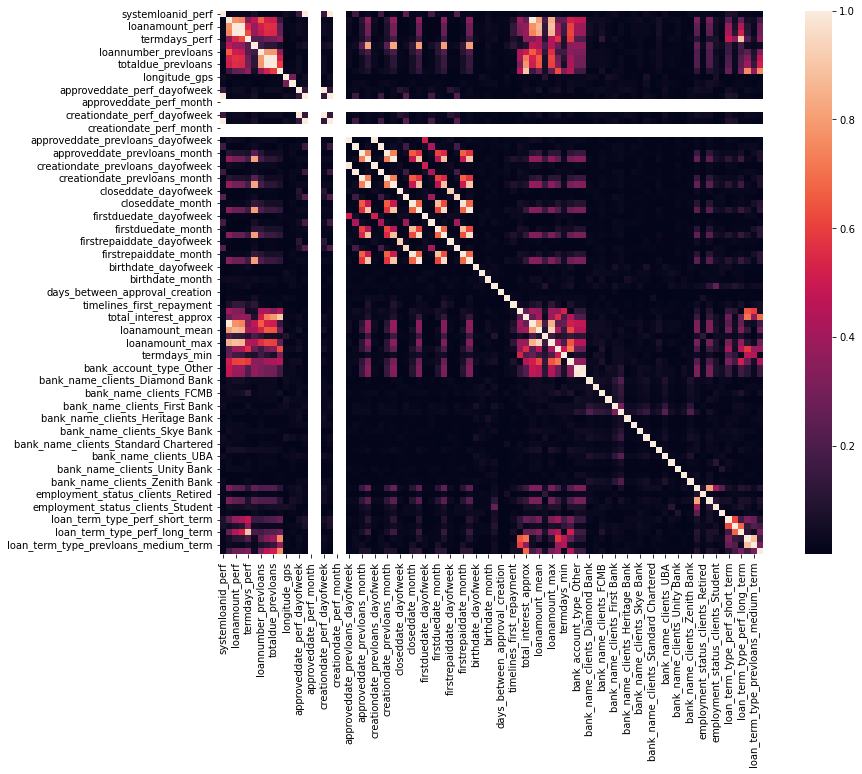

In [71]:
f, ax = plt.subplots(figsize=(15,10))
sns.heatmap(train_encoded.corr().abs(), square=True)

In [72]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert target label to numerical data
le = LabelEncoder()
train_encoded["good_bad_flag"] = le.fit_transform(train_encoded["good_bad_flag"])

Data Splitting

In [73]:
X = train_encoded.drop(["good_bad_flag", "customerid"], axis=1)
y = train_encoded["good_bad_flag"]

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5, stratify=y)

In [75]:
# Workflow pipleine
LR_pipeline = Pipeline([('smt', SMOTE(random_state=5)),
                        ('scaler', StandardScaler()),
                        ('classifier', LR(random_state=5))
                        ])

In [61]:
# Gridsearch for for optimization
from sklearn.model_selection import GridSearchCV

LR_param_range = [0.001, 0.01, 0.1]
LR_class_weight = [{0:0.01, 1:0.99}, {0:0.80,1:0.20}]
LR_param_grid = [{'classifier__C': LR_param_range, 'classifier__class_weight':LR_class_weight}]

gridsearch_LR = GridSearchCV(estimator=LR_pipeline,
                             param_grid=LR_param_grid,
                             n_jobs=-1,
                             cv=5)

In [62]:
train_encoded.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13693 entries, 0 to 13692
Columns: 81 entries, customerid to loan_term_type_prevloans_long_term
dtypes: float64(47), int64(3), object(1), uint8(30)
memory usage: 5.8+ MB


In [63]:
train_encoded.columns.get_loc("good_bad_flag")

6

In [64]:
columns = list(train_encoded.columns.values)
first = columns[0]
columns[0] = columns[6]
columns[6] = first
train_encoded = train_encoded[columns]

train_encoded.head()


,good_bad_flag,systemloanid_perf,loannumber_perf,loanamount_perf,totaldue_perf,termdays_perf,customerid,systemloanid_prevloans,loannumber_prevloans,loanamount_prevloans,...,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,loan_term_type_perf_short_term,loan_term_type_perf_medium_term,loan_term_type_perf_long_term,loan_term_type_prevloans_short_term,loan_term_type_prevloans_medium_term,loan_term_type_prevloans_long_term
0,1,301994762,0.833349,0.341494,0.340346,-0.223946,8a2a81a74ce8c05d014cfb32a0da1049,301682320,-0.673132,-0.700385,...,0,0,0,0,0,1,0,0,1,0
1,1,301994762,0.833349,0.341494,0.340346,-0.223946,8a2a81a74ce8c05d014cfb32a0da1049,301883808,1.467912,-0.700385,...,0,0,0,0,0,1,0,0,1,0
2,1,301994762,0.833349,0.341494,0.340346,-0.223946,8a2a81a74ce8c05d014cfb32a0da1049,301831714,1.162049,0.366243,...,0,0,0,0,0,1,0,0,1,0
3,1,301994762,0.833349,0.341494,0.340346,-0.223946,8a2a81a74ce8c05d014cfb32a0da1049,301923941,1.773776,0.366243,...,0,0,0,0,0,1,0,0,1,0
4,1,301994762,0.833349,0.341494,0.340346,-0.223946,8a2a81a74ce8c05d014cfb32a0da1049,301954468,2.079639,0.366243,...,0,0,0,0,0,1,0,0,1,0


In [65]:
second = columns[1]
columns[1] = columns[6]
columns[6] = second
train_encoded = train_encoded[columns]

train_encoded.head()

,good_bad_flag,customerid,loannumber_perf,loanamount_perf,totaldue_perf,termdays_perf,systemloanid_perf,systemloanid_prevloans,loannumber_prevloans,loanamount_prevloans,...,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,loan_term_type_perf_short_term,loan_term_type_perf_medium_term,loan_term_type_perf_long_term,loan_term_type_prevloans_short_term,loan_term_type_prevloans_medium_term,loan_term_type_prevloans_long_term
0,1,8a2a81a74ce8c05d014cfb32a0da1049,0.833349,0.341494,0.340346,-0.223946,301994762,301682320,-0.673132,-0.700385,...,0,0,0,0,0,1,0,0,1,0
1,1,8a2a81a74ce8c05d014cfb32a0da1049,0.833349,0.341494,0.340346,-0.223946,301994762,301883808,1.467912,-0.700385,...,0,0,0,0,0,1,0,0,1,0
2,1,8a2a81a74ce8c05d014cfb32a0da1049,0.833349,0.341494,0.340346,-0.223946,301994762,301831714,1.162049,0.366243,...,0,0,0,0,0,1,0,0,1,0
3,1,8a2a81a74ce8c05d014cfb32a0da1049,0.833349,0.341494,0.340346,-0.223946,301994762,301923941,1.773776,0.366243,...,0,0,0,0,0,1,0,0,1,0
4,1,8a2a81a74ce8c05d014cfb32a0da1049,0.833349,0.341494,0.340346,-0.223946,301994762,301954468,2.079639,0.366243,...,0,0,0,0,0,1,0,0,1,0


In [66]:
train_encoded_half = train_encoded[0:6800]

In [67]:
train_encoded_half.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6800 entries, 0 to 6799
Columns: 81 entries, good_bad_flag to loan_term_type_prevloans_long_term
dtypes: float64(47), int64(3), object(1), uint8(30)
memory usage: 2.9+ MB


In [68]:
X_gs_train = train_encoded_half.iloc[:,2:]
y_gs_train = train_encoded_half.iloc[:,0]

In [69]:
X_gs_train

,loannumber_perf,loanamount_perf,totaldue_perf,termdays_perf,systemloanid_perf,systemloanid_prevloans,loannumber_prevloans,loanamount_prevloans,totaldue_prevloans,termdays_prevloans,...,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,loan_term_type_perf_short_term,loan_term_type_perf_medium_term,loan_term_type_perf_long_term,loan_term_type_prevloans_short_term,loan_term_type_prevloans_medium_term,loan_term_type_prevloans_long_term
0,0.833349,0.341494,0.340346,-0.223946,301994762,301682320,-0.673132,-0.700385,-0.632297,0.296245,...,0,0,0,0,0,1,0,0,1,0
1,0.833349,0.341494,0.340346,-0.223946,301994762,301883808,1.467912,-0.700385,-0.632297,0.296245,...,0,0,0,0,0,1,0,0,1,0
2,0.833349,0.341494,0.340346,-0.223946,301994762,301831714,1.162049,0.366243,0.395115,0.296245,...,0,0,0,0,0,1,0,0,1,0
3,0.833349,0.341494,0.340346,-0.223946,301994762,301923941,1.773776,0.366243,0.461706,0.296245,...,0,0,0,0,0,1,0,0,1,0
4,0.833349,0.341494,0.340346,-0.223946,301994762,301954468,2.079639,0.366243,0.461706,0.296245,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6795,-1.250649,-1.242676,-1.220762,-0.223946,301998723,301928536,-0.673132,-0.700385,-0.632297,0.296245,...,0,0,0,0,0,1,0,0,1,0
6796,0.601794,1.133578,1.030138,-0.223946,301973188,301748075,-0.061405,0.366243,0.461706,0.296245,...,0,0,0,0,0,1,0,0,1,0
6797,0.601794,1.133578,1.030138,-0.223946,301973188,301777762,0.550322,1.432870,1.631814,3.024206,...,0,0,0,0,0,1,0,0,0,1
6798,0.601794,1.133578,1.030138,-0.223946,301973188,301714184,-0.367268,0.366243,0.461706,0.296245,...,0,0,0,0,0,1,0,0,1,0


In [70]:
y_gs_train

0       1
1       1
2       1
3       1
4       1
       ..
6795    0
6796    0
6797    0
6798    0
6799    0
Name: good_bad_flag, Length: 6800, dtype: int64

In [71]:
import dill

In [72]:
# Fitting dataset to get hyperparameters
gridsearch_LR.fit(X_gs_train, y_gs_train)
gridsearch_best_estimator_LR = gridsearch_LR.best_estimator_
dill.dump(gridsearch_best_estimator_LR, open('LogisticRegression_gridsearch_classweight.pkl', 'wb'))

In [63]:
# confusion matrix
def draw_confusion_matrix(conf_matrix, classifier_name):
    fig, ax = plt.subplots(figsize = (5,5))
    ax.matshow(conf_matrix, cmap = plt.cm.Greens, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
         for j in range(conf_matrix.shape[1]):
                 ax.text(x=j, y=i, s=conf_matrix[i, j], va = 'center', ha = 'center')
    plt.title('Confusion Matrix for %s' % classifier_name)
    plt.xlabel('Predicted label')
    plt.ylabel('True')
    
    plt.tight_layout()
    plt.show()

In [76]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from scipy import interp

In [80]:
X_train.shape

(10954, 79)

In [81]:
y_train.shape

(10954,)

In [76]:
# Getting previously pickled files
with open('LogisticRegression_gridsearch_classweight.pkl', 'rb') as f:
    LogisticRegression_classifier = dill.load(f)

In [77]:
class_weights = class_weight.compute_class_weight('balanced', 
                                                  classes=[0,1], 
                                                  y=train_encoded['good_bad_flag'])

weights = {0: class_weights[0], 1:class_weights[1]}
weights

{0: 2.708267405063291, 1: 0.6132109270040305}

In [78]:
lr1 = LR(class_weight=weights, max_iter=1000)
lr1.fit(X_train, y_train)

LogisticRegression(class_weight={0: 2.708267405063291, 1: 0.6132109270040305},
                   max_iter=1000)

In [79]:

y_pred_test = lr1.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("ROC AUC:", roc_auc_score(y_test, y_pred_test))


              precision    recall  f1-score   support

           0       0.20      0.58      0.29       506
           1       0.83      0.46      0.59      2233

    accuracy                           0.48      2739
   macro avg       0.51      0.52      0.44      2739
weighted avg       0.71      0.48      0.53      2739

Accuracy: 0.47973713033953996
ROC AUC: 0.5196703596253821


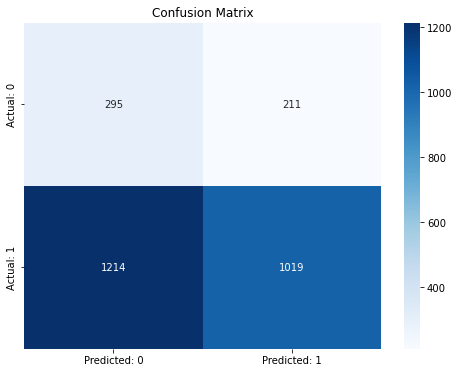

In [80]:
# print(classification_report(y_test, y_pred_test))
# print("Accuracy:", accuracy_score(y_test, y_pred_test))
# print("ROC AUC:", roc_auc_score(y_test, y_pred_test))

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Predicted: 0', 'Predicted: 1'], 
            yticklabels=['Actual: 0', 'Actual: 1'])
plt.title('Confusion Matrix')
plt.show()

In [82]:
from sklearn.metrics import roc_curve

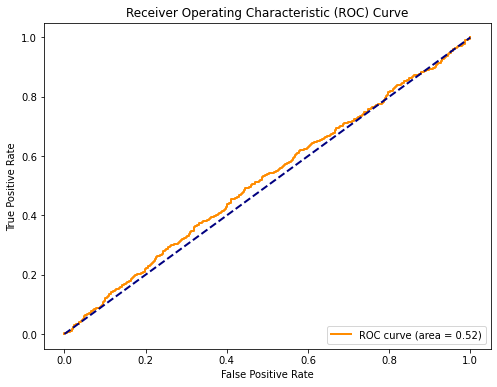

In [83]:
y_pred_prob = lr1.predict_proba(X_test)[:,1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Random Forest

In [84]:
from sklearn.ensemble import RandomForestClassifier

In [85]:
rf1 = RandomForestClassifier(n_estimators=100, random_state=5)
rf1.fit(X_train, y_train)

y_pred_rf1 = rf1.predict(X_test)


In [86]:
print(classification_report(y_test, y_pred_rf1))
print("Accuracy:", accuracy_score(y_test, y_pred_rf1))
print("ROC AUC:", roc_auc_score(y_test, y_pred_rf1))

              precision    recall  f1-score   support

           0       0.96      0.68      0.80       506
           1       0.93      0.99      0.96      2233

    accuracy                           0.94      2739
   macro avg       0.95      0.84      0.88      2739
weighted avg       0.94      0.94      0.93      2739

Accuracy: 0.9357429718875502
ROC AUC: 0.8360219241028837


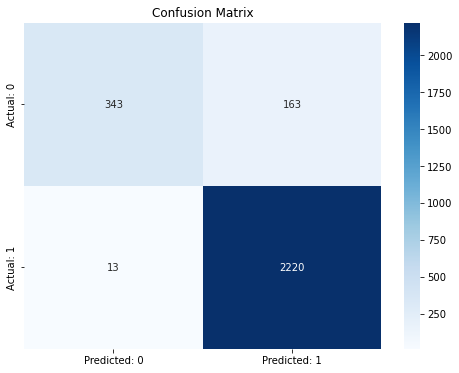

In [87]:
cm = confusion_matrix(y_test, y_pred_rf1)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Predicted: 0', 'Predicted: 1'], 
            yticklabels=['Actual: 0', 'Actual: 1'])
plt.title('Confusion Matrix')
plt.show()

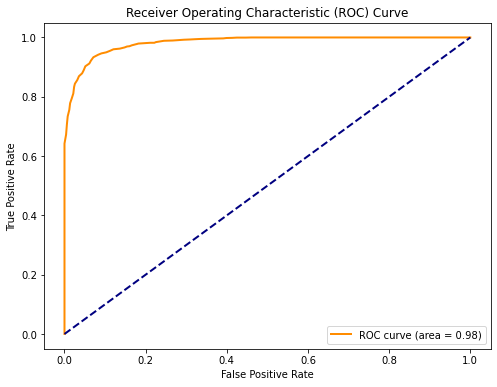

In [88]:
y_pred_probb = rf1.predict_proba(X_test)[:,1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_probb)
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [89]:
feature_importances = rf1.feature_importances_
feature_importances

array([5.25334685e-02, 3.09121017e-02, 1.46270440e-02, 2.23658561e-02,
       7.87420462e-03, 2.28278116e-02, 8.36317378e-03, 2.59477252e-03,
       5.30831453e-03, 2.33386888e-03, 5.65610754e-02, 5.58896190e-02,
       2.04824431e-02, 3.04419581e-02, 0.00000000e+00, 0.00000000e+00,
       2.06819625e-02, 3.14229132e-02, 0.00000000e+00, 0.00000000e+00,
       9.89870595e-03, 1.68361279e-02, 7.31225528e-03, 1.25937856e-03,
       1.02183052e-02, 1.70605021e-02, 7.42671958e-03, 1.19536988e-03,
       9.99879519e-03, 1.70303331e-02, 6.81058716e-03, 1.05488315e-03,
       8.22574540e-03, 1.63649660e-02, 7.70663041e-03, 1.05896874e-03,
       9.97586460e-03, 1.77961666e-02, 7.19588392e-03, 1.10852866e-03,
       2.64344993e-02, 4.66603510e-02, 3.45268323e-02, 4.39395841e-02,
       5.12107611e-05, 1.07018492e-04, 4.11072556e-02, 6.09737388e-03,
       5.48682145e-03, 3.04825175e-02, 3.65502051e-02, 5.70073302e-03,
       1.51734330e-02, 3.55908273e-02, 6.34858242e-03, 6.05563272e-03,
      

In [90]:
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})
features_df = features_df.sort_values(by='Importance', ascending=False)


In [91]:
features_df[0:40]

,Feature,Importance
10,longitude_gps,0.056561
11,latitude_gps,0.055890
0,systemloanid_perf,0.052533
41,birthdate_day,0.046660
43,birthdate_year,0.043940
46,timelines_first_repayment,0.041107
50,loanamount_mean,0.036550
53,termdays_mean,0.035591
42,birthdate_month,0.034527
17,creationdate_perf_day,0.031423


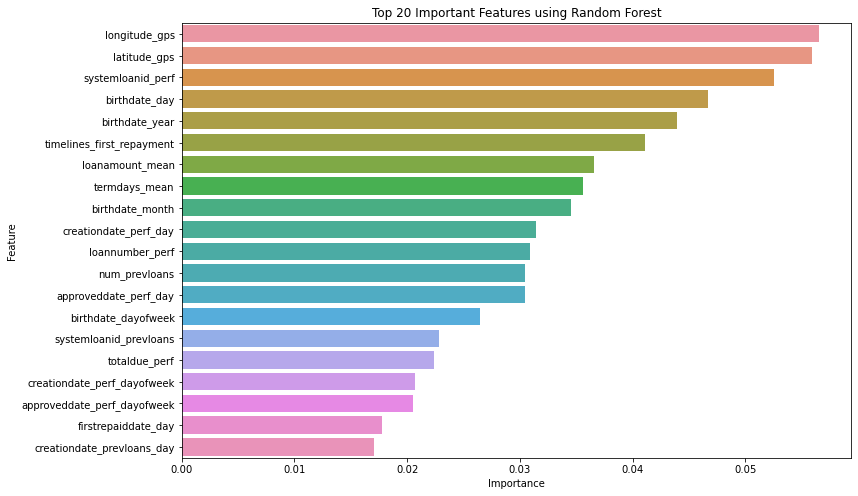

In [92]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df.head(20))  # Displaying top 20 features
plt.title('Top 20 Important Features using Random Forest')
plt.show()

In [93]:
indices = np.argsort(feature_importances)[::-1]
indices

array([10, 11,  0, 41, 43, 46, 50, 53, 42, 17,  1, 49, 13, 40,  5,  3, 16,
       12, 37, 25, 29, 21, 33, 52,  2, 24, 28, 36, 20, 63,  6, 32,  4, 34,
       57, 26, 22, 38, 30, 56, 54, 70, 47, 55, 51, 59, 62, 48, 81,  8, 77,
       75, 74, 78, 66, 80, 61, 58, 82, 69, 60,  7,  9, 79, 83, 84, 67, 65,
       23, 27, 39, 35, 31, 72, 64, 85, 71, 73, 68, 45, 44, 76, 14, 15, 18,
       19])

In [94]:
features = X_train.columns

1 longitude_gps 0.056561075447986664
2 latitude_gps 0.05588961904112868
3 systemloanid_perf 0.05253346852939123
4 birthdate_day 0.04666035098133386
5 birthdate_year 0.04393958407920772
6 timelines_first_repayment 0.04110725557191743
7 loanamount_mean 0.036550205106452446
8 termdays_mean 0.03559082725421561
9 birthdate_month 0.03452683227739045
10 creationdate_perf_day 0.0314229132184914
11 loannumber_perf 0.0309121017397646
12 num_prevloans 0.030482517512303877
13 approveddate_perf_day 0.030441958100489837
14 birthdate_dayofweek 0.02643449928405205
15 systemloanid_prevloans 0.022827811601518144
16 totaldue_perf 0.02236585613935606
17 creationdate_perf_dayofweek 0.02068196250479862
18 approveddate_perf_dayofweek 0.020482443118764074
19 firstrepaiddate_day 0.01779616662950765
20 creationdate_prevloans_day 0.017060502115628633
21 closeddate_day 0.01703033310132155
22 approveddate_prevloans_day 0.016836127915860397
23 firstduedate_day 0.016364965964043
24 loanamount_max 0.01517343304967777

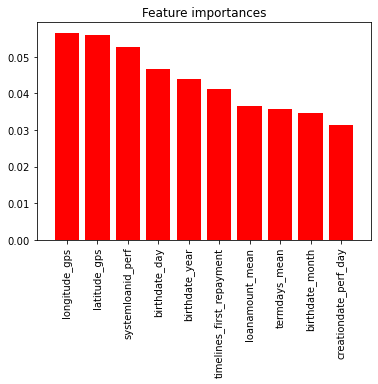

In [95]:


for f in range(X_train.shape[1]):
    print (f+1, features[indices[f]], feature_importances[indices[f]])
    
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), feature_importances[indices[:10]], color="r", align="center")
plt.xticks(rotation=90)
plt.xticks(range(10), features[indices[:10]])
plt.xlim([-1, 10])
plt.show()



In [96]:
features_df[50:]

,Feature,Importance
77,employment_status_clients_Self-Employed,0.005276
75,employment_status_clients_Permanent,0.005242
74,bank_name_clients_Zenith Bank,0.004987
78,employment_status_clients_Student,0.003794
66,bank_name_clients_Skye Bank,0.003616
80,loan_term_type_perf_short_term,0.003486
61,bank_name_clients_Fidelity Bank,0.003429
58,bank_name_clients_Diamond Bank,0.003366
82,loan_term_type_perf_long_term,0.003253
69,bank_name_clients_Sterling Bank,0.002822


In [ ]:
"creationdate_perf_year", "creationdate_perf_month", "approveddate_perf_month", "approveddate_perf_year"

In [97]:
# retraining using 20 of the features
important_features = features_df["Feature"].head(20).tolist()
important_features

['longitude_gps',
 'latitude_gps',
 'systemloanid_perf',
 'birthdate_day',
 'birthdate_year',
 'timelines_first_repayment',
 'loanamount_mean',
 'termdays_mean',
 'birthdate_month',
 'creationdate_perf_day',
 'loannumber_perf',
 'num_prevloans',
 'approveddate_perf_day',
 'birthdate_dayofweek',
 'systemloanid_prevloans',
 'totaldue_perf',
 'creationdate_perf_dayofweek',
 'approveddate_perf_dayofweek',
 'firstrepaiddate_day',
 'creationdate_prevloans_day']

In [98]:
X_train_reduced = X_train[important_features]
X_test_reduced = X_test[important_features]

In [99]:
rf1_new = RandomForestClassifier(n_estimators=100, random_state=5)
rf1_new.fit(X_train_reduced, y_train)

RandomForestClassifier(random_state=5)

In [100]:
y_pred_rf1_new = rf1_new.predict(X_test_reduced)

In [101]:
print(classification_report(y_test, y_pred_rf1_new))
print("Accuracy:", accuracy_score(y_test, y_pred_rf1_new))
print("ROC AUC:", roc_auc_score(y_test, y_pred_rf1_new))

              precision    recall  f1-score   support

           0       0.97      0.80      0.88       506
           1       0.96      0.99      0.98      2233

    accuracy                           0.96      2739
   macro avg       0.96      0.90      0.93      2739
weighted avg       0.96      0.96      0.96      2739

Accuracy: 0.9587440671778021
ROC AUC: 0.8982748885297611


In [112]:
test_predictions = rf1.predict(test_encoded)

In [116]:
submission_df = test_merged[['customerid']].copy()
submission_df['Good_Bad_flag'] = test_predictions


In [117]:
submission_path = "/home/pc/Desktop/CreditDefault/submission/submission_logistic_regression1.csv"
submission_df.to_csv(submission_path, index=False)